Let’s first load all the necessary libraries:

In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time

import pandas as pd
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\meh026\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """


import the data

In [2]:
df = pd.read_json('Automotive_5.json', lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


Data Preprocessing

In [3]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 30 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

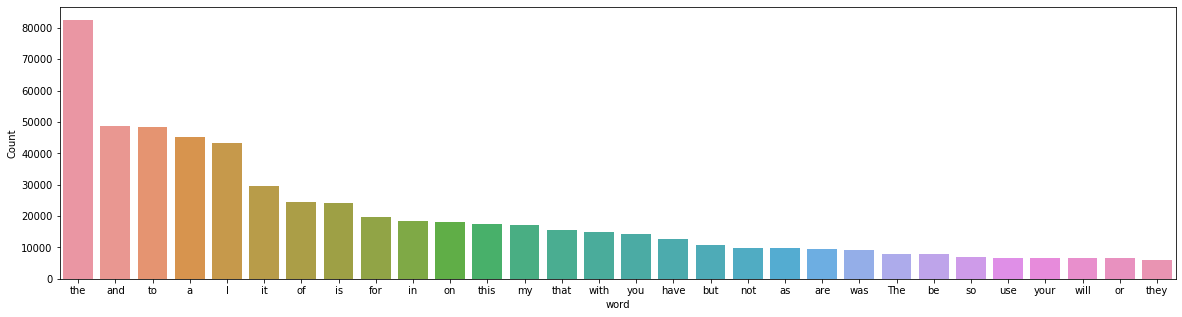

In [4]:
freq_words(df['reviewText'])

In [5]:
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

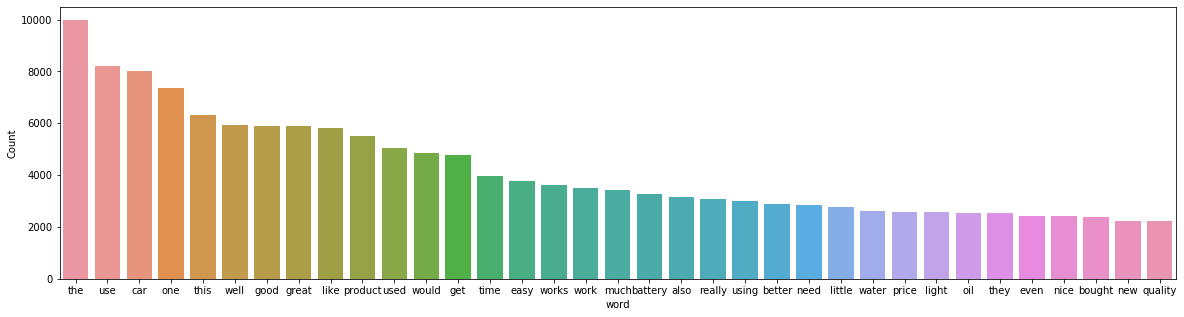

In [7]:
freq_words(reviews, 35)

In [8]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [9]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [10]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'snap', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


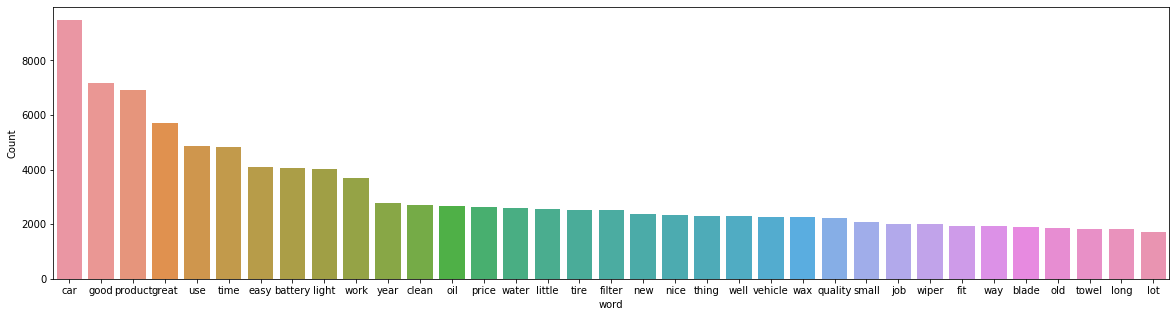

In [11]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

Building an LDA model

In [13]:
dictionary = corpora.Dictionary(reviews_2)

In [14]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [15]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [16]:
lda_model.print_topics()

[(0,
  '0.036*"oil" + 0.026*"filter" + 0.017*"change" + 0.016*"car" + 0.016*"engine" + 0.015*"good" + 0.012*"inverter" + 0.012*"price" + 0.011*"product" + 0.011*"bosch"'),
 (1,
  '0.027*"wiper" + 0.026*"blade" + 0.019*"good" + 0.011*"plastic" + 0.011*"windshield" + 0.010*"quality" + 0.010*"work" + 0.009*"fit" + 0.009*"side" + 0.009*"small"'),
 (2,
  '0.035*"battery" + 0.027*"car" + 0.017*"power" + 0.013*"device" + 0.013*"light" + 0.012*"unit" + 0.010*"charger" + 0.010*"use" + 0.010*"time" + 0.010*"plug"'),
 (3,
  '0.053*"light" + 0.025*"bulb" + 0.018*"bright" + 0.017*"great" + 0.014*"easy" + 0.012*"install" + 0.011*"fit" + 0.009*"white" + 0.009*"jeep" + 0.009*"good"'),
 (4,
  '0.028*"tire" + 0.019*"hose" + 0.013*"pressure" + 0.012*"use" + 0.011*"water" + 0.011*"gauge" + 0.010*"easy" + 0.010*"air" + 0.008*"jack" + 0.008*"time"'),
 (5,
  '0.041*"car" + 0.024*"towel" + 0.021*"product" + 0.021*"clean" + 0.016*"water" + 0.016*"good" + 0.014*"leather" + 0.012*"great" + 0.012*"use" + 0.011*"w

Topics Visualization

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\meh026\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.101950 -0.073665       1        1  19.055861
1      0.112558 -0.062311       2        1  16.016306
2      0.013735  0.178783       3        1  15.873899
4      0.193707 -0.072376       4        1  14.340077
3      0.114238 -0.000911       5        1  12.624616
6     -0.211478 -0.163823       6        1  11.321659
0     -0.120809  0.194302       7        1  10.767590, topic_info=    Category         Freq     Term        Total  loglift  logprob
150  Default  4916.000000    light  4916.000000  30.0000  30.0000
38   Default  3047.000000  battery  3047.000000  29.0000  29.0000
3    Default  9344.000000      car  9344.000000  28.0000  28.0000
168  Default  2106.000000      oil  2106.000000  27.0000  27.0000
523  Default  2147.000000      wax  2147.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
16    Topic7   445.566742      new  2217.518066   0.6238  -4.8869
9     Topic7   458.678406    great  5013.575195  -0.1629  -4.8579
334   Topic7   380.624756     well  2120.037598   0.5113  -5.0444
21    Topic7   423.569214     time  4637.463867  -0.1646  -4.9375
30    Topic7   317.402252  quality  2007.809204   0.3840  -5.2261

[435 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1292       1  0.996243     absorbent
1649       7  0.993128  acceleration
1164       4  0.997694      accurate
2802       2  0.268937       adapter
2802       3  0.729264       adapter
...      ...       ...           ...
271        5  0.056660          year
271        6  0.143315          year
271        7  0.214973          year
6681       2  0.989082        zipper
16406      3  0.998041         zubie

[672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 3, 5, 4, 7, 1])